In [2]:
import numpy as np
import matplotlib.pyplot as plt
import agama
import galpy
agama.setUnits( mass=1., length=1., velocity=1.)  # Msun, kpc, km/s

# Load Galpy Potentials
Watch out for funny units

In [3]:
from galpy.potential.Cautun20 import Cautun20 as g_C20
from galpy.potential.mwpotentials import MWPotential2014 as g_B14
from galpy.potential.mwpotentials import McMillan17 as g_M17
from galpy.potential import vcirc

/home/tom/miniconda3/lib/python3.9/site-packages/galpy-1.8.0.dev0-py3.9-linux-x86_64.egg/galpy/potential/AdiabaticContractionWrapperPotential.py:101: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Phi0= integrate.quad(new_rforce_func,rgrid[0],rgrid[-1])[0]\



In [4]:
import astropy.units as u
nR=1000
R_space = np.geomspace(0.1,200,nR)

g_vc_M17 = vcirc(g_M17,R=R_space/g_M17[0]._ro, use_physical=True)
g_vc_B14 = vcirc(g_B14,R=R_space/g_B14[0]._ro, use_physical=True)*g_B14[0]._vo
g_vc_C20 = vcirc(g_C20,R=R_space/g_C20[0]._ro, use_physical=True)

In [5]:
g_vc = {'M17':g_vc_M17, 'B14':g_vc_B14, 'C20':g_vc_C20}
Pots= list(g_vc.keys())

In [6]:

MWVCircData=np.loadtxt('Eilers19_Vcirc.txt')
vdata_r=MWVCircData[:,0]
vdata_vc=MWVCircData[:,1]
vdata_vc_u=MWVCircData[:,2]
vdata_vc_l=MWVCircData[:,3]


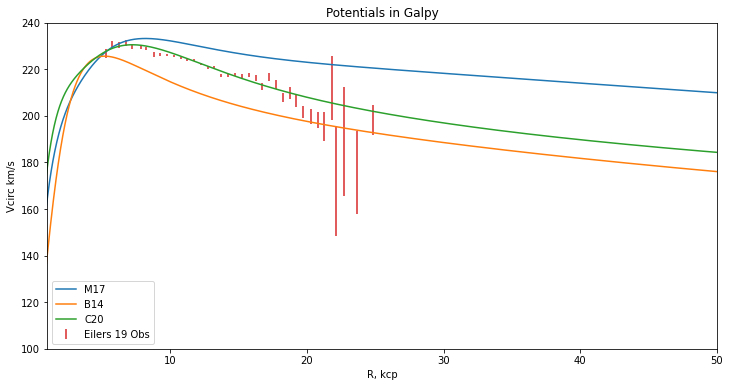

In [7]:
plt.figure(figsize=(12,6))
for p in Pots:
    plt.plot(R_space, g_vc[p], label=p)
# plt.xscale('log')
plt.ylim([100, 240])
plt.errorbar(vdata_r, vdata_vc, yerr=[vdata_vc_u, vdata_vc_l], ls = 'none',
            label='Eilers 19 Obs')
# plt.scatter(vdata_r, vdata_vc,c='black')
# plt.xlim([R_space[0],R_space[-1]])
plt.xlim([1, 50])
plt.xlabel('R, kcp')
plt.ylabel('Vcirc km/s')
plt.title('Potentials in Galpy')
plt.legend()
plt.show()

In [8]:
components = ['DM_Halo','disc', 'bulge', 'cgm']
g_C20_seperate = { com: g_C20[i] for (i,com) in enumerate(components)}
g_C20_vc_seperate = { com: vcirc(g_C20_seperate[com],R=R_space/g_C20[0]._ro, use_physical=True)
                     for com in components}


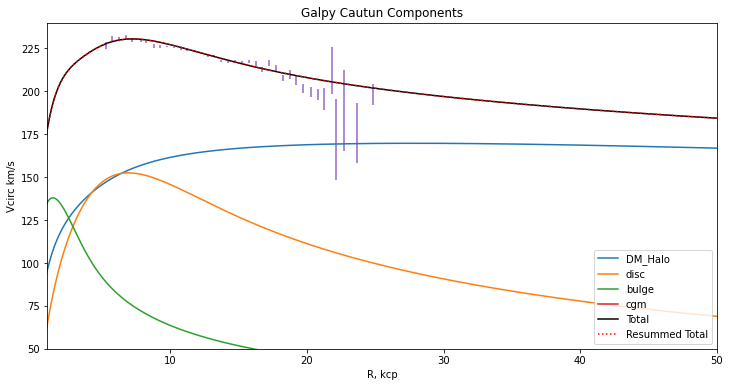

In [9]:

plt.figure(figsize=(12,6))
total_vc = np.zeros_like(g_vc_C20**2)
for com in components:
    plt.plot(R_space, g_C20_vc_seperate[com], label=com)
    total_vc = total_vc  + (g_C20_vc_seperate[com]**2)
total_vc = np.sqrt(total_vc)

plt.plot(R_space, g_vc_C20, label='Total', c='k')
plt.plot(R_space, total_vc, label='Resummed Total', c='red', ls = ':')

# plt.xscale('log')
plt.ylim([50, 240])
plt.errorbar(vdata_r, vdata_vc, yerr=[vdata_vc_u, vdata_vc_l], ls = 'none')
# plt.scatter(vdata_r, vdata_vc,c='black')
# plt.xlim([R_space[0],R_space[-1]])
plt.xlim([1, 50])
plt.xlabel('R, kcp')
plt.ylabel('Vcirc km/s')
plt.title('Galpy Cautun Components')
plt.legend()
plt.show()

# Agama Load and Comparison

In [15]:
from Cautun20 import C20_pot as a_C20
a_M17 = agama.Potential("McMillan17.ini")

In [16]:
def a_vcirc(pot,R):
    vc = np.sqrt(-R*pot.force(np.stack((R,np.zeros_like(R), np.zeros_like(R))).transpose())[:,0])

    return vc

def a_pot_R(pot,R):
    return pot.potential(np.stack((R,np.zeros_like(R), np.zeros_like(R))).transpose())

In [17]:
components = ['DM_Halo','disc', 'bulge', 'cgm']
a_C20_seperate = {'DM_Halo': a_C20[0],
                  'disc':  a_C20[1],
                  'bulge': a_C20[2],
                  'cgm': a_C20[3]}

a_C20_vc = a_vcirc(a_C20,R_space)
a_C20_vc_seperate = { com: a_vcirc(a_C20_seperate[com],R_space)
                     for com in components}

In [18]:
a_M17_vc = a_vcirc(a_M17, R_space)

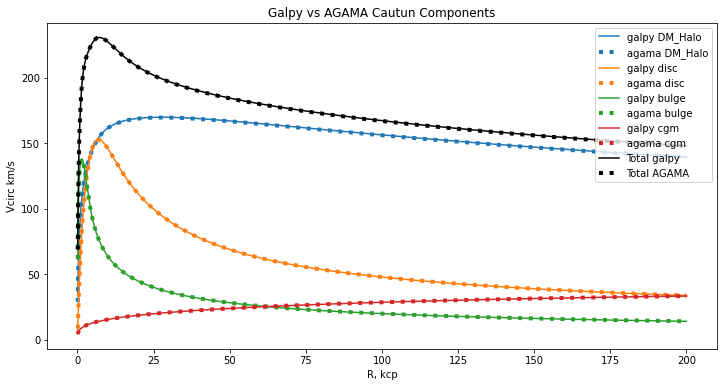

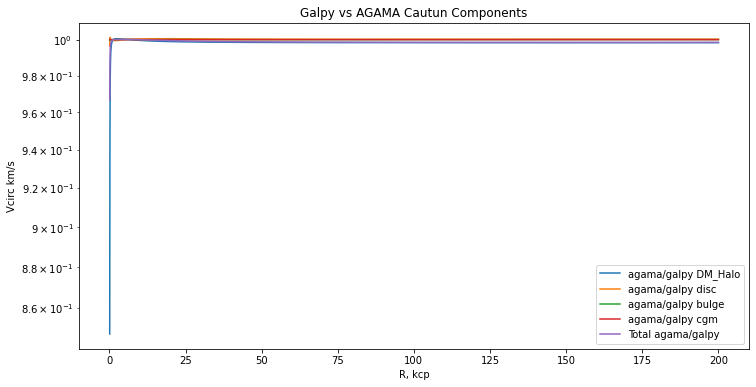

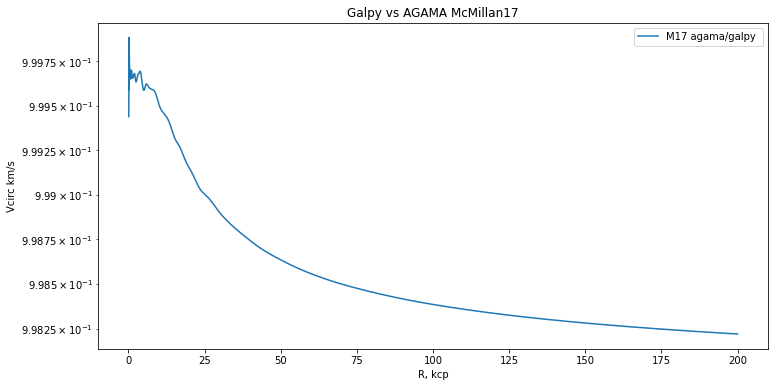

In [19]:


plt.figure(figsize=(12,6))
for com in components:
    p = plt.plot(R_space, g_C20_vc_seperate[com], label=f'galpy {com}')
    plt.plot(R_space, a_C20_vc_seperate[com], label=f'agama {com}', ls =':', c = p[0].get_color(),linewidth=4)

plt.plot(R_space, g_vc_C20, label='Total galpy', c='k')
plt.plot(R_space, a_C20_vc, label='Total AGAMA', c='k', ls = ':', linewidth=4)

plt.xlabel('R, kcp')
plt.ylabel('Vcirc km/s')
plt.title('Galpy vs AGAMA Cautun Components')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
for com in components:
    plt.plot(R_space, a_C20_vc_seperate[com]/ g_C20_vc_seperate[com]
             , label=f'agama/galpy {com}')

plt.plot(R_space, a_C20_vc/ g_vc_C20,
          label=f'Total agama/galpy ')

plt.xlabel('R, kcp')
plt.ylabel('Vcirc km/s')
plt.title('Galpy vs AGAMA Cautun Components')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))

plt.plot(R_space, a_M17_vc/ g_vc_M17,
          label=f'M17 agama/galpy ')

plt.xlabel('R, kcp')
plt.ylabel('Vcirc km/s')
plt.title('Galpy vs AGAMA McMillan17')
plt.yscale('log')
plt.legend()
plt.show()